In [1]:
import os
import numpy as np
import json
import pandas as pd
from scipy.misc import imread

import keras
from keras.models import Model
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Dropout, Cropping2D, Input, merge
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras import backend as K
from keras.utils import to_categorical

# from metrics import f1 as f1_score


def UNet(filters_dims, activation='relu', kernel_initializer='glorot_uniform', padding='same'):
    inputs = Input((480, 640, 3))
    new_inputs = inputs
    conv_layers = []
    # Encoding Phase
    for i in range(len(filters_dims) - 1):
        conv = Conv2D(filters_dims[i], 3, activation=activation, padding=padding,
                      kernel_initializer=kernel_initializer)(new_inputs)
        conv = Conv2D(filters_dims[i], 3, activation=activation, padding=padding,
                      kernel_initializer=kernel_initializer)(conv)
        conv_layers.append(conv)
        new_inputs = MaxPooling2D(pool_size=(2, 2))(conv)
        # op = BatchNormalization()(op)

    # middle phase
    conv = Conv2D(filters_dims[-1], 3, activation=activation, padding=padding,
                  kernel_initializer=kernel_initializer)(new_inputs)
    conv = Conv2D(filters_dims[-1], 3, activation=activation, padding=padding,
                  kernel_initializer=kernel_initializer)(conv)
    new_inputs = Dropout(0.5)(conv)

    filters_dims.reverse()
    conv_layers.reverse()

    # Decoding Phase
    for i in range(1, len(filters_dims)):
        up = Conv2D(filters_dims[i], 3, activation=activation, padding=padding,
                    kernel_initializer=kernel_initializer)(UpSampling2D(size=(2, 2))(new_inputs))
        concat = merge([conv_layers[i-1], up], mode='concat', concat_axis=3)
        conv = Conv2D(filters_dims[i], 3, activation=activation, padding=padding,
                      kernel_initializer=kernel_initializer)(concat)
        new_inputs = Conv2D(filters_dims[i], 3, activation=activation, padding=padding,
                            kernel_initializer=kernel_initializer)(conv)
    outputs = Conv2D(2, 1, activation='softmax', padding='same',
                     kernel_initializer='glorot_uniform')(new_inputs)

    model = Model(input=inputs, output=outputs, name='UNet')
    model.compile(optimizer=Adam(lr=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'mse', f1_score])
    return model

def f1_score(y_true, y_pred):
    '''
    Calculates the F1 by using keras.backend
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall))



/home/renjie/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
cfg = {
    "filters_dims" : [64, 128, 256, 512],
    "activation" : "relu",
    "kernel_initializer" : "glorot_uniform",
    "padding" : "same"
}


In [3]:
model_1 = UNet(filters_dims=cfg['filters_dims'],
             activation='relu', 
             kernel_initializer='glorot_uniform', 
             padding='same')

model_2 = UNet(filters_dims=cfg['filters_dims'],
             activation='relu', 
             kernel_initializer='glorot_uniform', 
             padding='same')

/home/renjie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/renjie/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/renjie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="UNet", inputs=Tensor("in..., outputs=Tensor("co...)`


In [10]:
weights_path = os.path.join(os.getcwd(),'..','weights')
weights_names = os.listdir(weights_path)
best_train_weight = os.path.join(weights_path, weights_names[0])
best_val_weight = os.path.join(weights_path, weights_names[1])
best_train_weight, best_val_weight

('/home/renjie/Documents/GitHub/CascadedFCN/notebook/../weights/UNet.77-0.01.hdf5',
 '/home/renjie/Documents/GitHub/CascadedFCN/notebook/../weights/UNet.35-0.20.hdf5')

In [5]:
data_path = os.path.join(os.getcwd(), '..', 'data', 'Augments', 'val')
image_path = os.path.join(data_path, 'Original')
mask_path = os.path.join(data_path, 'SegMask_Wound_Bg')

# image_names = os.listdir(image_path)
# mask_names = os.listdir(mask_path)

In [6]:
seed = 1

In [7]:
from keras.preprocessing.image import ImageDataGenerator

In [8]:
image_datagen = ImageDataGenerator()
mask_datagen = ImageDataGenerator()

image_generator = image_datagen.flow_from_directory(image_path,
                                                        (480, 640),
                                                        class_mode=None,
                                                        batch_size=1,
                                                        seed=seed)
mask_generator = mask_datagen.flow_from_directory(mask_path,
                                                  (480, 640),
                                                  color_mode='grayscale',
                                                      classes=None,
                                                      class_mode=None,
                                                      batch_size=1,
                                                      seed=seed)
test_gen = zip(image_generator, mask_generator)

Found 200 images belonging to 1 classes.
Found 200 images belonging to 1 classes.


In [14]:
model_1.load_weights(best_train_weight)
# model_2.load_weights(best_val_weight)

<function matplotlib.pyplot.show>

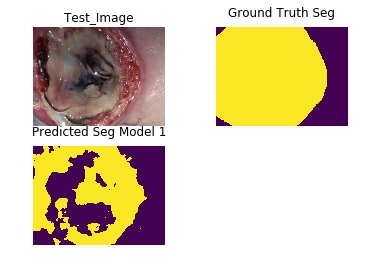

In [18]:
import matplotlib.pyplot as plt

(test_image, test_mask) = next(test_gen)
test_image = test_image.reshape(480,640,3)
test_mask = test_mask.reshape(480,640)

pred_1 = model_1.predict(np.expand_dims(test_image, axis = 0))
pred_1 = pred_1.reshape(480,640,2)
pred_Wound_1 = np.round(pred_1[:,:,1])
# pred_Wound = pred[:,:,1]


fig, ax = plt.subplots(2, 2)

ax[0, 0].imshow(test_image.astype('uint8'))
ax[0, 0].set_axis_off()
ax[0, 0].set_title('Test_Image')

ax[0, 1].matshow(test_mask)
ax[0, 1].set_axis_off()
ax[0, 1].set_title('Ground Truth Seg')

ax[1, 0].matshow(pred_Wound_1)
ax[1, 0].set_axis_off()
ax[1, 0].set_title('Predicted Seg Model 1')

# ax[1, 1].matshow(pred_Wound_2)
ax[1, 1].set_axis_off()
# ax[1, 1].set_title('Predicted Seg Model 2')
plt.show

In [ ]:
pred = model.predict(np.expand_dims(test_image, axis = 0))

In [ ]:
pred = pred.reshape(480,640,2)

In [ ]:
pred_BG = pred[:,:,0]
pred_Wound = pred[:,:,1]

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(pred_Wound)

In [ ]:
plt.imshow(test_mask)

In [ ]:
plt.imshow(test_image.astype('uint8'))